___

___
# Titanic Survival with Python


We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.


## Import Libraries
Let's import some libraries to get started!

In [903]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import metrics as met
from sklearn.metrics import classification_report
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [904]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [905]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

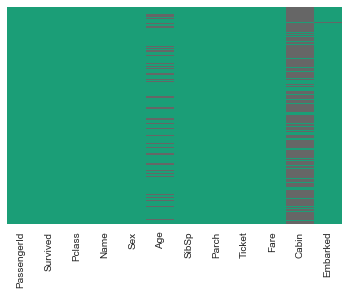

In [906]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='Dark2')

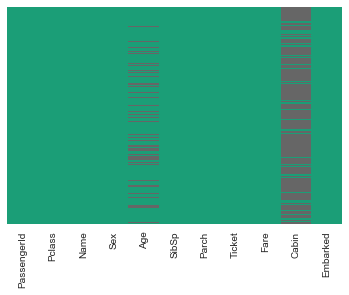

In [907]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='Dark2')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

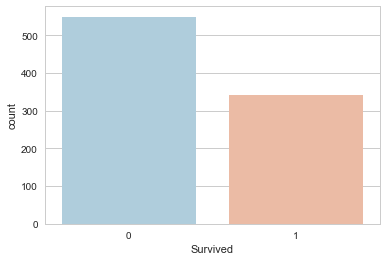

In [908]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

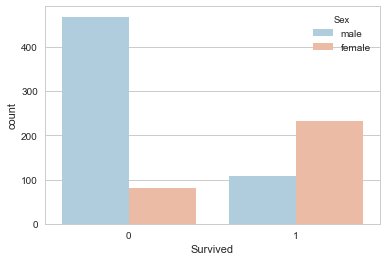

In [909]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

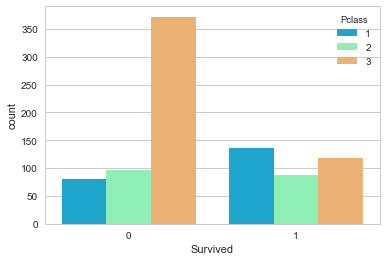

In [910]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

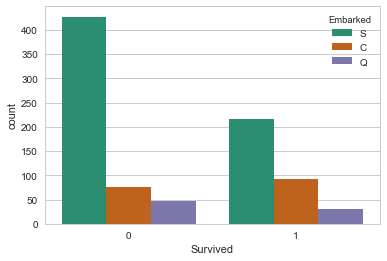

In [911]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Embarked',data=train,palette='Dark2')

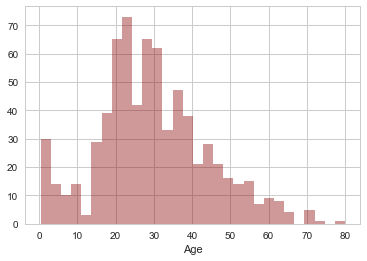

In [912]:
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

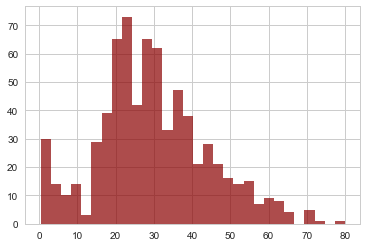

In [913]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

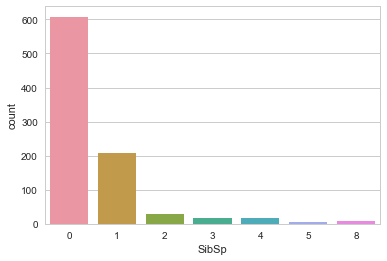

In [914]:
sns.countplot(x='SibSp',data=train)

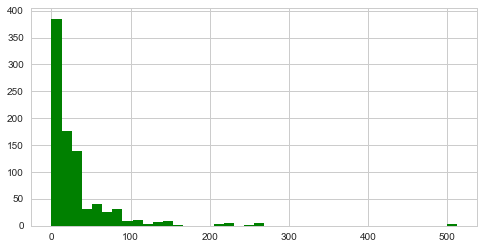

In [915]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


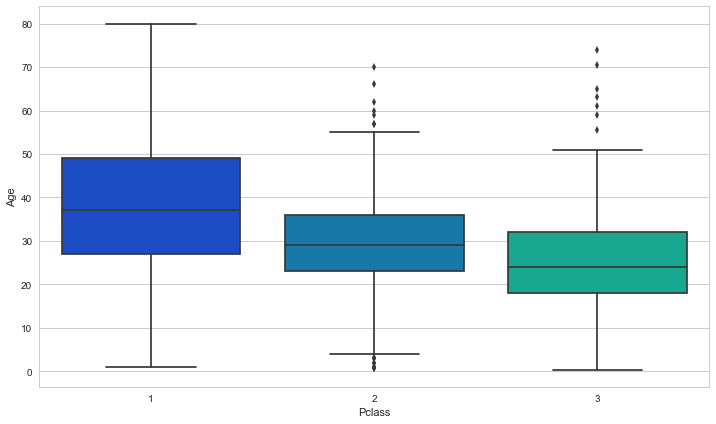

In [916]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [917]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [918]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
test['Age'] = test[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

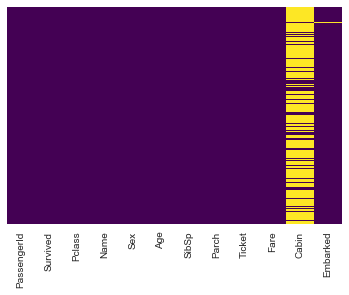

In [919]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

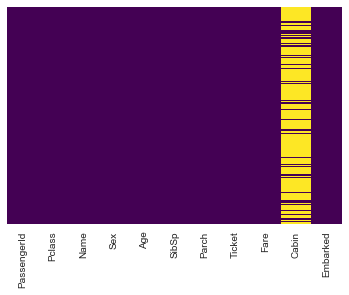

In [920]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [921]:
train.drop('Cabin',axis=1,inplace=True)
test.drop('Cabin',axis=1,inplace=True)

In [922]:
train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [923]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [924]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

sex_test = pd.get_dummies(test['Sex'],drop_first=True)
embark_test = pd.get_dummies(test['Embarked'],drop_first=True)

In [925]:
#train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
train.drop(['Sex','Embarked'],axis=1,inplace=True)
test.drop(['Sex','Embarked'],axis=1,inplace=True)

In [926]:
train = pd.concat([train,sex,embark],axis=1)
test = pd.concat([test,sex_test,embark_test],axis=1)

In [927]:
print(train.columns)
print(test.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'male', 'Q', 'S'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'male', 'Q', 'S'],
      dtype='object')


In [928]:
# we extract the title from each name
train['title'] = train['Name'].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip())
test['title'] = test['Name'].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip())
# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
train['title'] = train.title.map( Title_Dictionary )
titles = pd.get_dummies(train.title)
titles.head()
test['title'] = test.title.map(Title_Dictionary)
tests = pd.get_dummies(test.title)
tests.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,0,1,0,0


In [929]:
train = pd.concat([train,titles],axis=1)
test = pd.concat([test,tests],axis=1)

In [930]:
train.drop(['Name','title'],axis=1,inplace=True)
test.drop(['Name','title'],axis=1,inplace=True)

In [931]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,male,Q,S,Master,Miss,Mr,Mrs,Officer,Royalty
0,1,0,3,22.0,1,0,A/5 21171,7.2500,1,0,1,0,0,1,0,0,0
1,2,1,1,38.0,1,0,PC 17599,71.2833,0,0,0,0,0,0,1,0,0
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,0,0,1,0,1,0,0,0,0
3,4,1,1,35.0,1,0,113803,53.1000,0,0,1,0,0,0,1,0,0
4,5,0,3,35.0,0,0,373450,8.0500,1,0,1,0,0,1,0,0,0


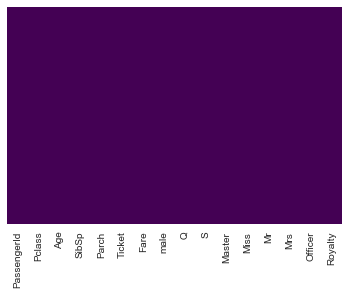

In [932]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [933]:
train['Family_Size'] = train['SibSp'].values + train['Parch'].values + 1
test['Family_Size'] = test['SibSp'].values + test['Parch'].values + 1

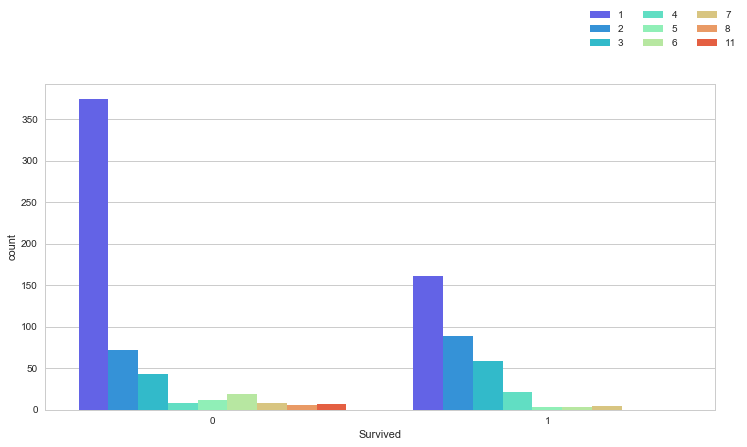

In [934]:
plt.figure(figsize = (12,6))
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Family_Size',data=train,palette='rainbow')
plt.legend(loc='upper left', bbox_to_anchor=(0.8, 1.25),
          ncol=3, fancybox=True, shadow=True)

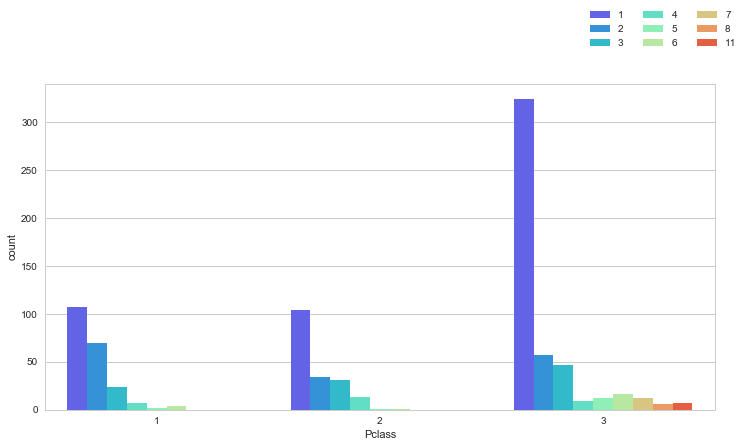

In [935]:
plt.figure(figsize = (12,6))
sns.set_style('whitegrid')
sns.countplot(x='Pclass',hue='Family_Size',data=train,palette='rainbow')
plt.legend(loc='upper left', bbox_to_anchor=(0.8, 1.25),
          ncol=3, fancybox=True, shadow=True)

In [936]:
train.drop(['SibSp','Parch','PassengerId','Ticket'],axis=1,inplace=True)

In [937]:
test.drop(['SibSp','Parch','PassengerId','Ticket'],axis=1,inplace=True)

In [938]:
test.head()

,Pclass,Age,Fare,male,Q,S,Master,Miss,Mr,Mrs,Officer,Royalty,Family_Size
0,3,34.5,7.8292,1,1,0,0,0,1,0,0,0,1
1,3,47.0,7.0000,0,0,1,0,0,0,1,0,0,2
2,2,62.0,9.6875,1,1,0,0,0,1,0,0,0,1
3,3,27.0,8.6625,1,0,1,0,0,1,0,0,0,1
4,3,22.0,12.2875,0,0,1,0,0,0,1,0,0,3


In [939]:
train.head()

,Survived,Pclass,Age,Fare,male,Q,S,Master,Miss,Mr,Mrs,Officer,Royalty,Family_Size
0,0,3,22.0,7.2500,1,0,1,0,0,1,0,0,0,2
1,1,1,38.0,71.2833,0,0,0,0,0,0,1,0,0,2
2,1,3,26.0,7.9250,0,0,1,0,1,0,0,0,0,1
3,1,1,35.0,53.1000,0,0,1,0,0,0,1,0,0,2
4,0,3,35.0,8.0500,1,0,1,0,0,1,0,0,0,1


In [902]:
print(test['Fare'].isnull)

<bound method NDFrame.isnull of 0        7.8292
1        7.0000
2        9.6875
3        8.6625
4       12.2875
5        9.2250
6        7.6292
7       29.0000
8        7.2292
9       24.1500
10       7.8958
11      26.0000
12      82.2667
13      26.0000
14      61.1750
15      27.7208
16      12.3500
17       7.2250
18       7.9250
19       7.2250
20      59.4000
21       3.1708
22      31.6833
23      61.3792
24     262.3750
25      14.5000
26      61.9792
27       7.2250
28      30.5000
29      21.6792
         ...   
388      7.7500
389     21.0750
390     93.5000
391     39.4000
392     20.2500
393     10.5000
394     22.0250
395     60.0000
396      7.2500
397     79.2000
398      7.7750
399      7.7333
400    164.8667
401     21.0000
402     59.4000
403     47.1000
404     27.7208
405     13.8625
406     10.5000
407    211.5000
408      7.7208
409     13.7750
410      7.7500
411     90.0000
412      7.7750
413      8.0500
414    108.9000
415      7.2500
416      8.0500
417     

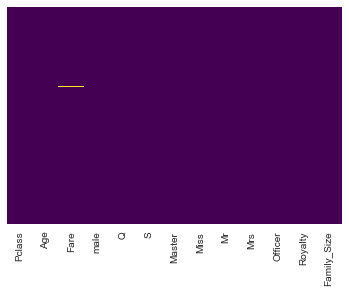

In [941]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')
#test.dropna(inplace=True)

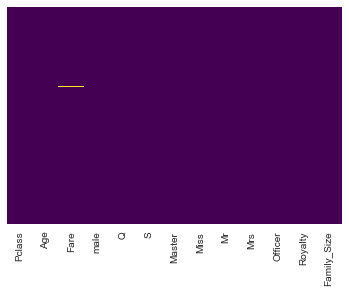

In [942]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [943]:
X = train.drop('Survived',axis=1)
y = train['Survived']

Great! Our data is ready for our model!

# Building a models

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [944]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=101)

In [945]:
# Models
classifiers = {'Gradient Boosting Classifier':GradientBoostingClassifier(),'Adaptive Boosting Classifier':AdaBoostClassifier(),
               'Linear Discriminant Analysis':LinearDiscriminantAnalysis(),'Logistic Regression':LogisticRegression(),
               'Random Forest Classifier': RandomForestClassifier(),'Decision Tree Classifier': DecisionTreeClassifier() }

## Training and Predicting

In [946]:
for Name,classify in classifiers.items():
    classify.fit(X_train,y_train)
    y_pred = classify.predict(X_valid)
    print('Accuracy Score of '+str(Name) + " : " +str(met.accuracy_score(y_valid,y_pred)))

Accuracy Score of Gradient Boosting Classifier : 0.835205992509
Accuracy Score of Adaptive Boosting Classifier : 0.842696629213
Accuracy Score of Linear Discriminant Analysis : 0.85393258427
Accuracy Score of Logistic Regression : 0.857677902622
Accuracy Score of Random Forest Classifier : 0.812734082397
Accuracy Score of Decision Tree Classifier : 0.771535580524


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## GridSearchCV

In [947]:
param_grid = {'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001,0.0001]}
gscv = GridSearchCV(SVC(),param_grid,verbose=2)

In [948]:
gscv.fit(X_train,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ......................................... C=0.1, gamma=1 -   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ......................................... C=0.1, gamma=1 -   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ......................................... C=0.1, gamma=1 -   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ....................................... C=0.1, gamma=0.1 -   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ....................................... C=0.1, gamma=0.1 -   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ....................................... C=0.1, gamma=0.1 -   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.1, gamma=0.0001 .............................................
[CV] .................................... C=0.1, gamma=0.0001 -   0.0s
[CV] C=0.1, gamma=0.0001 .............................................
[CV] .................................... C=0.1, gamma=0.0001 -   0.0s
[CV] C=0.1, gamma=0.0001 .............................................
[CV] .................................... C=0.1, gamma=0.0001 -   0.0s
[CV] C=1, gamma=1 ....................................................
[CV] ........................................... C=1, gamma=1 -   0.0s
[CV] C=1, gamma=1 ....................................................
[CV] ........................................... C=1, gamma=1 -   0.0s
[CV] C=1, gamma=1 ....................................................
[CV] ........................................... C=1, gamma=1 -   0.0s
[CV] C=1, gamma=0.1 ..................................................
[CV] ......................................... C=1, gamma=0.1 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [949]:
predictions = gscv.predict(X_valid)
print(met.accuracy_score(y_valid,predictions))

0.835205992509


In [950]:
print(gscv.best_params_)
print(gscv.best_score_)

{'C': 100, 'gamma': 0.0001}
0.7845659163987139


In [951]:
param_grid = {'learning_rate':[0.1,1,10,100,1000]}
gbccv = GridSearchCV(GradientBoostingClassifier(),param_grid,verbose=2)

Let's move on to evaluate our model!

In [952]:
gbccv.fit(X_train,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] learning_rate=0.1 ...............................................
[CV] ...................................... learning_rate=0.1 -   0.0s
[CV] learning_rate=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... learning_rate=0.1 -   0.0s
[CV] learning_rate=0.1 ...............................................
[CV] ...................................... learning_rate=0.1 -   0.0s
[CV] learning_rate=1 .................................................
[CV] ........................................ learning_rate=1 -   0.0s
[CV] learning_rate=1 .................................................
[CV] ........................................ learning_rate=1 -   0.0s
[CV] learning_rate=1 .................................................
[CV] ........................................ learning_rate=1 -   0.0s
[CV] learning_rate=10 ................................................
[CV] ....................................... learning_rate=10 -   0.0s
[CV] learning_rate=10 ................................................
[CV] ....................................... learning_rate=10 -   0.0s
[CV] learning_rate=10 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [953]:
predictions_train = gbccv.predict(X_test)
predictions_test = gbccv.predict(test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## K-Fold Sampling

In [954]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3,random_state=101)
for Name,classify in classifiers.items():
    for train_KF, test_KF in kfold.split(X,y):
        X_train,X_test = X.iloc[train_KF], X.iloc[test_KF]
        y_train,y_test = y.iloc[train_KF], y.iloc[test_KF]
        classify.fit(X_train,y_train)
        y_pred = classify.predict(X_test)
        print('Accuracy Score of '+str(Name) + " : " +str(met.accuracy_score(y_test,y_pred)))
        print(classification_report(y_test,y_pred))
        print('---------------------------------------------------------------------------')

Accuracy Score of Gradient Boosting Classifier : 0.808080808081
             precision    recall  f1-score   support

          0       0.85      0.86      0.85       192
          1       0.74      0.71      0.72       105

avg / total       0.81      0.81      0.81       297

---------------------------------------------------------------------------
Accuracy Score of Gradient Boosting Classifier : 0.834459459459
             precision    recall  f1-score   support

          0       0.82      0.90      0.86       168
          1       0.86      0.74      0.79       128

avg / total       0.84      0.83      0.83       296

---------------------------------------------------------------------------
Accuracy Score of Gradient Boosting Classifier : 0.831081081081
             precision    recall  f1-score   support

          0       0.84      0.91      0.87       189
          1       0.81      0.69      0.75       107

avg / total       0.83      0.83      0.83       296

-----------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
